In [1]:
import os, sys, time
import itertools, functools

import librosa, librosa.display

import scipy

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import IPython
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm_nb, trange

import multiprocessing

import torch, torch.nn as nn, torch.nn.functional as F, torch.autograd as ag

In [2]:
def get_spectgorgamm(fname, hop_length=512, n_mels=128):
    y, sr = librosa.load(fname)
    S = librosa.feature.melspectrogram(y, sr=sr, hop_length=hop_length, n_mels=n_mels)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    
    return log_S, sr

def plot_spectrogramm(log_S, sr):
    plt.figure(figsize=(20,4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
    plt.title('mel power spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

In [ ]:
#!ffplay -nodisp -loglevel quiet -autoexit "./some-sound/cv_corpus_v1/cv_corpus_v1/cv-valid-test/sample-001169.mp3"

(128, 191)
CPU times: user 607 ms, sys: 693 ms, total: 1.3 s
Wall time: 543 ms


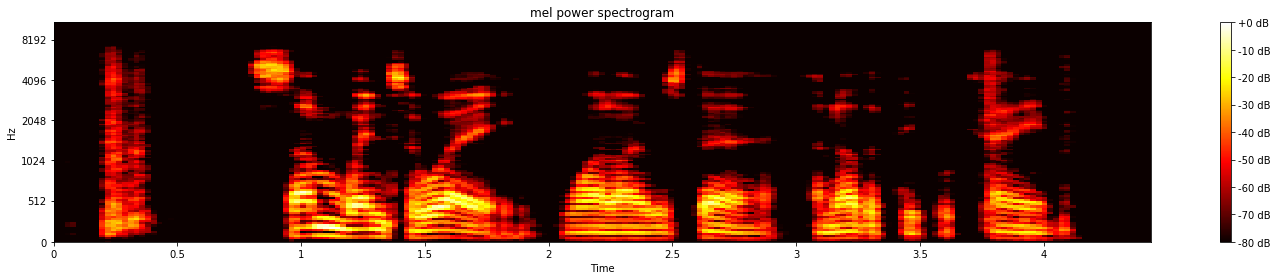

In [75]:
%%time
spec = get_spectgorgamm("./some-sound/cv_corpus_v1/cv_corpus_v1/cv-valid-test/sample-001169.mp3")
plot_spectrogramm(*spec)
print(spec[0].shape)

# Mining spectrogramms

In [ ]:
ls some-sound/cv_corpus_v1/cv_corpus_v1/cv-valid-dev/

In [3]:
descr = pd.read_csv('./some-sound/cv_corpus_v1/cv_corpus_v1/cv-valid-dev.csv')

In [20]:
%%timeit
descr[self_equal(descr['gender'])]

744 µs ± 8.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [3]:
def self_equal(sth):
    return sth == sth

def yield_all(sth, length):
    for i in range(length):
        yield sth[i]

def compute_spectrogram_and_save(fname_gender_save_to_dirname):
    fname, gender, save_to, dirname = (
        fname_gender_save_to_dirname[0].filename,
        fname_gender_save_to_dirname[0].gender,
        fname_gender_save_to_dirname[1],
        fname_gender_save_to_dirname[2])
    
    spec = get_spectgorgamm(dirname + '/' + fname[fname.rfind('/')+1:])
    np.save(save_to + '/' + gender + '_' + fname[fname.rfind('/')+1:], spec)

def mine_data_from_cv_corpus(dirname, save_to):
    '''There should be file `dirname`+".csv"'''
    data = pd.read_csv(dirname + '.csv')
    data = data[self_equal(data['gender'])]
    
    multiprocessing.Pool(os.cpu_count()).map(compute_spectrogram_and_save,
                                             zip(yield_all(data.iloc, data.shape[0]),
                                                 itertools.cycle((save_to,)),
                                                 itertools.cycle((dirname,))))

In [117]:
#mine_data_from_cv_corpus('./some-sound/cv_corpus_v1/cv_corpus_v1/cv-valid-dev',
#                         './some-sound/cv-valid-dev-melspecs/')

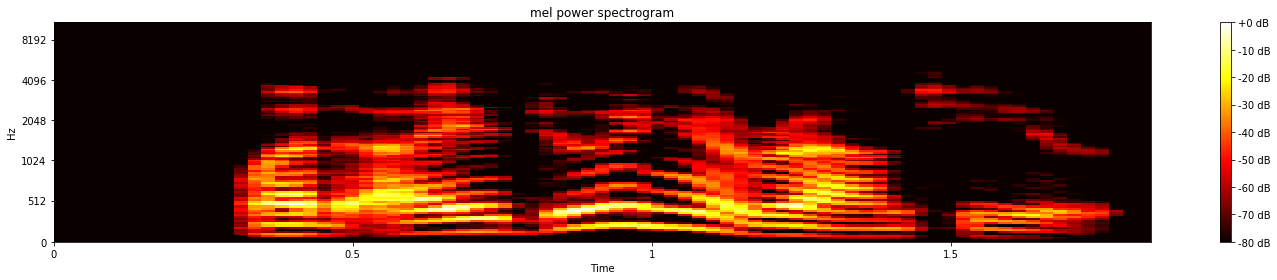

In [116]:
plot_spectrogramm(*np.load('./some-sound/cv-valid-dev-melspecs/male_sample-002514.mp3.npy'))

# Getting data

In [4]:
prefix = './some-sound/cv-valid-dev-melspecs/'
fnames = next(os.walk(prefix))[-1]
X = map((lambda s: np.load(prefix + s)[0]), fnames)
X = np.array([np.concatenate(( x, -80 * np.ones((128, max(0, 300 - x.shape[1]))) ), axis=-1)[:, :300] for x in X])
Y = np.array(list(map((lambda s: s[0] == 'm'), fnames))).astype('long')

<b>Preparing data</b>

In [5]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=0.1, random_state=512)

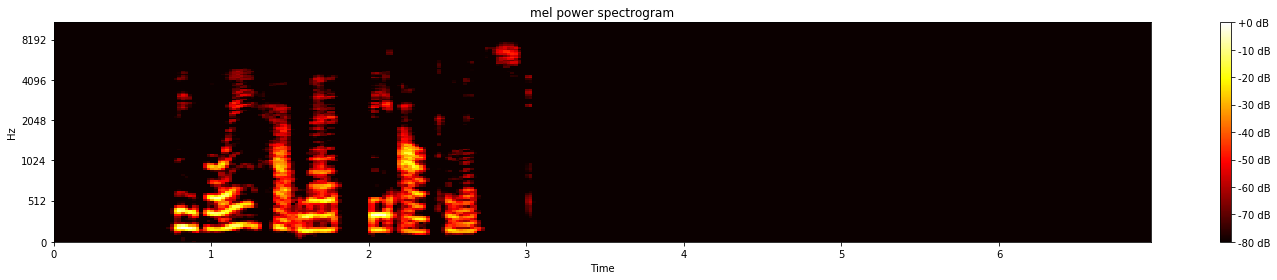

In [6]:
plot_spectrogramm(X[4], 22050)

# Train convolutional neural network

In [217]:
bla1 = np.array([[1, 2, 3, 4],
                 [5, 6, 7, 8]])
bla2 = np.array([[1, 2, 3, 4, 5, 6],
                 [7, 8, 9, 1, 2, 3]])

np.concatenate((bla1, bla2), axis=1)

array([[1, 2, 3, 4, 1, 2, 3, 4, 5, 6],
       [5, 6, 7, 8, 7, 8, 9, 1, 2, 3]])

In [35]:
x = torch.FloatTensor(X_tr[:10])

In [40]:
x_prep = x - torch.min(torch.min(x, 2, keepdim=True)[0], 1, keepdim=True)[0]
print(x_prep)
print(torch.max(torch.max(x_prep, 2, keepdim=True)[0], 1, keepdim=True)[0])
x_prep /= torch.max(torch.max(x_prep, 2, keepdim=True)[0], 1, keepdim=True)[0]
print(x_prep)


( 0 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000

( 1 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
            ...               ⋱              ...            
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000

( 2 ,.,.) = 
   0.0000   0.0000   0.0000  ...    0.0000   0.0000   0.0000
   0.0000   0.0000   0.0000  ...    0.0000 

In [156]:
class MyNN(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv1d(128, 256, 3)
        self.conv2 = nn.Conv1d(256, 512, 3)

        self.gmp1 = GlobalMaxPool1d()
        self.dropout = nn.Dropout(0.2)
        self.dense1 = nn.Linear(512, 2)

    def forward(self, x):
        x = x - torch.min(torch.min(x, 2, keepdim=True)[0], 1, keepdim=True)[0]
        x /= torch.max(torch.max(x, 2, keepdim=True)[0], 1, keepdim=True)[0]
        #x = torch.transpose(x, 1, 2)
        
        conv1_out = nn.LeakyReLU()(self.conv1(x))
        
        conv2_out = nn.LeakyReLU()(self.conv2(conv1_out))
        
        gmp1_out = self.gmp1(conv2_out)
        dense1_out = self.dense1(self.dropout(gmp1_out))
        
        return dense1_out

class GlobalMaxPool1d(nn.Module):
    def forward(self, inp):
        return torch.max(inp, dim=-1)[0]

In [157]:
def compute_loss_predict(x, y):
    x = ag.Variable(torch.FloatTensor(x))
    y = ag.Variable(torch.LongTensor(y))
    logits = model(x)
    return F.cross_entropy(logits, y).mean(), logits

def iterate_minibatches(x, y, batchsize):
    indices = np.random.permutation(np.arange(len(x)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield x[ix], y[ix]

In [158]:
model = MyNN()

In [159]:
model(ag.Variable(torch.FloatTensor(X[:2])))

Variable containing:
1.00000e-02 *
  5.3995  3.8901
  1.1547  2.0529
[torch.FloatTensor of size 2x2]

In [160]:
compute_loss(X[:20], Y[:20])

Variable containing:
 0.7015
[torch.FloatTensor of size 1]

<b>Training model</b>

In [161]:
batch_size = 10

In [162]:
opt = torch.optim.Adam(model.parameters())

In [163]:
train_loss = []
train_loss_avg = []

val_accuracy = []
val_accuracy_avg = []

train_accuracy = []
train_accuracy_avg = []

In [164]:
the_best_model = (None, -1e+1000)
last_update = 0
max_wait_num_epochs = 15

Train loss plot:


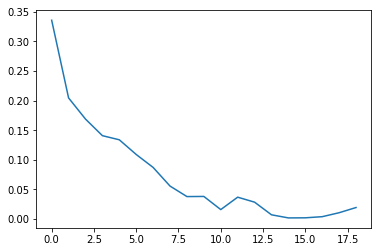

Train (blue) & validation (orange) accuracy plot:


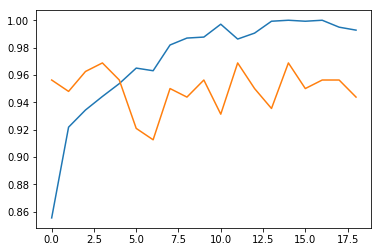

Epoch 17 took 19.113s
  training loss:	0.019263
  training accuracy:	0.992754
  validation accuracy:	0.943750
Best model validation accuracy:	0.968750
  last update 15 epochs ago


In [165]:
stop_after_epoch = 0

epoch = -1
while epoch - last_update <= max_wait_num_epochs:
    if stop_after_epoch:
        break
    start_time = time.time()
    
    model.train(True)
    for x_batch, y_batch in tqdm_nb(iterate_minibatches(X_tr, Y_tr, batch_size),
                                    total = -(-len(X_tr) // batch_size)):
        try:
            loss, logits = compute_loss_predict(x_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            train_loss.append(loss.data.numpy()[0])
            train_accuracy.append(np.mean(logits.max(1)[1].data.numpy() == y_batch))
        except KeyboardInterrupt as err:
            if stop_after_epoch:
                print('Stop now')
                raise err
            print('Stop after this epoch')
            stop_after_epoch += 1
    
    model.train(False)
    for x_batch, y_batch in tqdm_nb(iterate_minibatches(X_val, Y_val, batch_size),
                                    total = -(-len(X_val) // batch_size)):
        try:
            logits = model(ag.Variable(torch.FloatTensor(x_batch)))
            val_accuracy.append(np.mean(logits.max(1)[1].data.numpy() == y_batch))
        except KeyboardInterrupt as err:
            if stop_after_epoch:
                print('Stop now')
                raise err
            print('Stop after this epoch')
            stop_after_epoch += 1

    clear_output(True)
    
    train_loss_avg.append(np.mean(train_loss[-len(X_tr) // batch_size :]))
    val_accuracy_avg.append(np.mean(val_accuracy[-len(X_val) // batch_size :]))
    train_accuracy_avg.append(np.mean(train_accuracy[-len(X_tr) // batch_size :]))
    
    if val_accuracy_avg[-1] > the_best_model[1]:
        the_best_model = (model.state_dict(), val_accuracy_avg[-1])
        last_update = epoch
    
    print('Train loss plot:')
    plt.plot(train_loss_avg)
    plt.show()
    print('Train (blue) & validation (orange) accuracy plot:')
    plt.plot(train_accuracy_avg)
    plt.plot(val_accuracy_avg)
    plt.show()

    print('Epoch {} took {:.3f}s'.format(
        epoch, time.time() - start_time))
    print('  training loss:\t{:.6f}'.format(train_loss_avg[-1]))
    print('  training accuracy:\t{:.6f}'.format(train_accuracy_avg[-1]))
    print('  validation accuracy:\t{:.6f}'.format(val_accuracy_avg[-1]))
    
    print('Best model validation accuracy:\t{:.6f}'.format(the_best_model[1]))
    print('  last update {} epochs ago'.format(epoch - last_update))
    
    epoch += 1

In [167]:
#torch.save(model, '96.87_acc_model_128x300_spec.pt')

/home/abrikos/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type MyNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/abrikos/anaconda3/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type GlobalMaxPool1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
